### Feature Classifier 2022-03
The point of this file is to see how well a model can classify road segments given limited, proximal information from the cities centreline data.
Some of this data is already used for the classification of LTS; however, this model tries to use limited, easy to access datasets that may be transferrable across all cities in order to speed up the classification process without using all of the features used in the 2016 paper.

In [9]:
#Import all packages from model functions
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

Import train centreline data

In [12]:
train_data = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/centreline_train_spatial.csv')
print(train_data.shape)
train_data.head()

(47642, 22)


,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,...,geometry,CENTRELINE_ID,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,LINEAR_NAME_FULL,geometry_y,LTS str,high access,AREA_ID
0,6230,6231,14673896,12211,Ln S King E Jefferson,14673882,14673898,0,40.297145,14673896,...,LINESTRING (627377.1786732512 4832979.56364183...,14673896.0,201700.0,Laneway,CITY OF TORONTO,Ln S King E Jefferson,LINESTRING (627377.1782839079 4832979.56440503...,1,1,101.0
1,6524,6525,7807934,1863,Islington Ave,13468469,13468331,0,134.326236,7807934,...,LINESTRING (619276.0922559096 4832882.87983632...,7807934.0,201200.0,Major Arterial,CITY OF TORONTO,Islington Ave,LINESTRING (619276.0923099464 4832882.87969986...,4,0,101.0
2,14929,14930,30037062,19212,Trinity Bellwoods Park Trl,30036895,30037061,0,35.615169,30037062,...,LINESTRING (627811.5715102765 4834063.23264422...,30037062.0,204001.0,Trail,CITY OF TORONTO,Trinity Bellwoods Park Trl,LINESTRING (627811.5715217837 4834063.23304300...,1,1,2480182.0
3,45799,45800,111047,8292,Lancefield Ave,13452341,13452221,0,96.737868,111047,...,LINESTRING (637528.0535979696 4843961.99229576...,111047.0,201500.0,Local,CITY OF TORONTO,Lancefield Ave,LINESTRING (637528.0536655281 4843961.99286933...,1,1,2480112.0
4,12896,12897,14044599,12268,Ln W Ohara S Seaforth,14044585,14044208,0,50.034372,14044599,...,LINESTRING (626195.9889904017 4833376.29638667...,14044599.0,201700.0,Laneway,CITY OF TORONTO,Ln W Ohara S Seaforth,LINESTRING (626195.989373541 4833376.296085007...,1,1,2480169.0


#### Clean and feature engineer using model_functions.py

After evaluating the features in the model, many of them are similar. Ex. Arterial vs. Arterial Ramp. <br>
Before doing any other feature eng, create a function that combines these similar features. Convert to the majoy road types: <br>
Local, Collector, Arterial, Highway. Keep paths seperate. Do we lose info when we do this?

In [13]:
train_data['FEATURE_CODE_DESC'].unique()
def map_centreline_features(data):
    """
    Maps the centreline feature codes to their more like features.
    """
    data_m = data.copy()
    data_m['FEATURE_CODE_DESC'] = data_m['FEATURE_CODE_DESC'].replace({'Laneway':'Local',
                                                                       'Minor Arterial':'Arterial',
                                                                       'Major Arterial':'Arterial',
                                                                       'Major Arterial Ramp':'Arterial',
                                                                       'Walkway':'Trail',
                                                                       'Collector Ramp':'Collector',
                                                                       'Minor Arterial Ramp':'Arterial',
                                                                        })
    
    
    return data_m

train_data = map_centreline_features(train_data)
train_data['FEATURE_CODE_DESC']

0           Local
1        Arterial
2           Trail
3           Local
4           Local
           ...   
47637       Local
47638    Arterial
47639       Local
47640       Local
47641       Trail
Name: FEATURE_CODE_DESC, Length: 47642, dtype: object

In [14]:
# Split features/target
y_train_lts = train_data['LTS']
y_train_access = train_data['high access']
X_train = train_data.drop(['LTS','high access'], axis=1)

In [15]:
# Engineer features usign model functions.
keep_rows = ['FEATURE_CODE_DESC','geometry', 'AREA_ID']
X_train = droprows(X_train, keep_rows)
X_train = add_regions(X_train, 2, 3)
X_train = dummy(X_train, dummy_feats=['FEATURE_CODE_DESC','x_region','y_region'])
X_train.head()

Principal component 0
explains 74.4413377102346 % of the variance in "lon" and "lat".
Principal component 1
explains 25.558662289765383 % of the variance in "lon" and "lat".


,geometry,AREA_ID,FEATURE_CODE_DESC_Arterial,FEATURE_CODE_DESC_Busway,FEATURE_CODE_DESC_Collector,FEATURE_CODE_DESC_Local,FEATURE_CODE_DESC_Other,FEATURE_CODE_DESC_Other Ramp,FEATURE_CODE_DESC_Pending,FEATURE_CODE_DESC_Trail,x_region_2,x_region_3,y_region_2,y_region_3
0,"LINESTRING (627377.179 4832979.564, 627338.580...",101.0,0,0,0,1,0,0,0,0,0,0,0,0
1,"LINESTRING (619276.092 4832882.880, 619236.760...",101.0,1,0,0,0,0,0,0,0,0,0,1,0
2,"LINESTRING (627811.572 4834063.233, 627812.257...",2480182.0,0,0,0,0,0,0,0,1,0,0,0,0
3,"LINESTRING (637528.054 4843961.992, 637499.750...",2480112.0,0,0,0,1,0,0,0,0,0,1,1,0
4,"LINESTRING (626195.989 4833376.296, 626182.135...",2480169.0,0,0,0,1,0,0,0,0,0,0,0,0


In [16]:
X_train.shape

(47642, 14)

#### Feature Selection
Preprocessing and Cross Validation to choose the best features for the model

Define some models that we would like to test

In [17]:
model_log = LogisticRegression()
model_svm = svm.SVC()
model_rf = RandomForestClassifier()

Use the normal feature selector function to see CV results without spatial autocorrolation

In [28]:
feature_selector(model_log, splits=10, X=X_train.iloc[:,2:], y=y_train_access, i=10)

Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected features: ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Other', 'FEATURE_CODE_DESC_Pending', 'FEATURE_CODE_DESC_Trail', 'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']
Selected fea

<br>Use the spatial cross validation function to get a better look at the feature performance

In [29]:
spatial_cv(model_log, grouper=X_train['AREA_ID'], splits=141, X=X_train.iloc[:,2:9], y=y_train_access)

Mean fold weighted F1 Score: 0.9042886333447919
Mean fold accuracy Score: 0.9077549816080779
Mean fold MSE: 0.09224501839192215


Finally, select Features to be used in hyper parameter tuning

In [26]:
#features = ['FEATURE_CODE_DESC_Collector', 'FEATURE_CODE_DESC_Collector Ramp', 
#             'FEATURE_CODE_DESC_Laneway', 'FEATURE_CODE_DESC_Local', 
#             'FEATURE_CODE_DESC_Major Arterial', 'FEATURE_CODE_DESC_Major Arterial Ramp', 
#             'FEATURE_CODE_DESC_Minor Arterial', 'FEATURE_CODE_DESC_Other', 
#             'FEATURE_CODE_DESC_Trail', 'FEATURE_CODE_DESC_Walkway']

features = ['FEATURE_CODE_DESC_Arterial', 'FEATURE_CODE_DESC_Collector', 
            'FEATURE_CODE_DESC_Local', 'FEATURE_CODE_DESC_Trail',
            'x_region_2', 'x_region_3', 'y_region_2', 'y_region_3']

#### Tune hyperparameters
Use random search, and try using groupkfold for the cv in the tuning

In [34]:
# Get a set of group kfold using the neighbourhood grouper.
# Unfrtuantely, the 141 cross validations massively increases runtime of the search.
group_kfold = GroupKFold(n_splits=10)
grouper = X_train['AREA_ID']

neighbour_kfold = group_kfold.split(X_train, y_train_access, grouper)

# Create list to be passed to search.
train_index, val_index = [list(tt) for tt in zip(*neighbour_kfold)]
neighbour_cv = [*zip(train_index, val_index)]

In [35]:
cv = StratifiedKFold(n_splits=10)

# Choose hyper-params
params_log = {'penalty': ('l1', 'l2'),
              'fit_intercept': (True, False),
              'C': loguniform(1e-3, 1e2),
              'class_weight': ('balanced')
             }

# Do the search (might take awhile)
r_search_log = RandomizedSearchCV(estimator=model_log,
                                  param_distributions=params_log,
                                  n_iter=200,
                                  scoring='f1_weighted',
                                  cv=neighbour_cv,
                                 )

r_search_log.fit(X_train[features], y_train_access)

RandomizedSearchCV(cv=[(array([    2,     3,     4, ..., 47639, 47640, 47641]),
                        array([    0,     1,    37, ..., 47623, 47633, 47638])),
                       (array([    0,     1,     2, ..., 47638, 47640, 47641]),
                        array([    3,     5,    12, ..., 47584, 47634, 47639])),
                       (array([    0,     1,     2, ..., 47638, 47639, 47641]),
                        array([    9,    16,    26, ..., 47628, 47636, 47640])),
                       (array([    0,     1,     2, ..., 47639, 47640, 47641]),
                        array([    7,    14,    20, ..., 47598, 47608, 47615])),
                       (array([    0,     1,     2, ......
                        array([   17,    22,    27, ..., 47613, 47624, 47629])),
                       (array([    0,     1,     2, ..., 47639, 47640, 47641]),
                        array([   30,    66,    67, ..., 47616, 47626, 47632]))],
                   estimator=LogisticRegression(), n_i

In [36]:
print('best weighted score', r_search_log.best_score_)
print('best estimator: ',r_search_log.best_estimator_)

best weighted score 0.9097777499846543
best estimator:  LogisticRegression(C=18.412899722997675, class_weight='c')


<br>Train the model:

In [37]:
model_features = LogisticRegression(C=18.412899722997675, class_weight='balanced')
model_features.fit(X_train[features], y_train_access)

y_pred = model_features.predict(X_train[features])

#See week 9 lec 3 slide 57 when choosing class balance

#### Model Evaluation
Metrics, visualizations included

In [38]:
print('accuracy: ', accuracy_score(y_train_access, y_pred))
print('weighted f1: ', f1_score(y_train_access, y_pred, average='weighted'))

accuracy:  0.8936652533478863
weighted f1:  0.8993600297066069


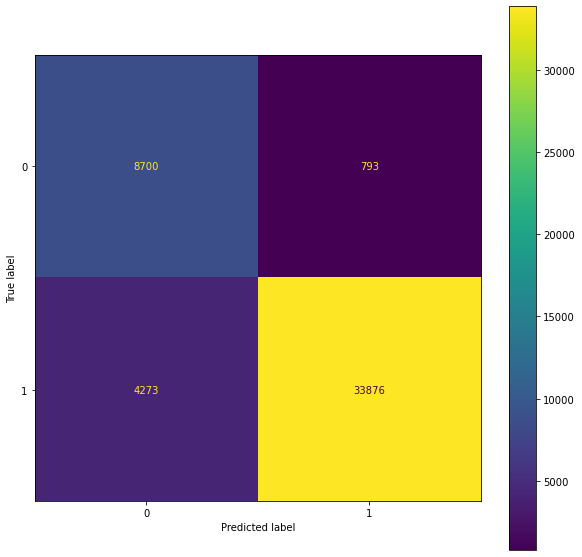

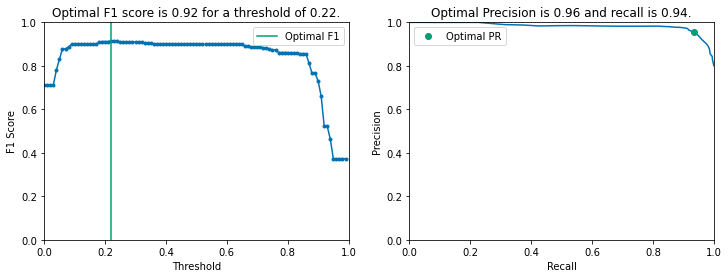

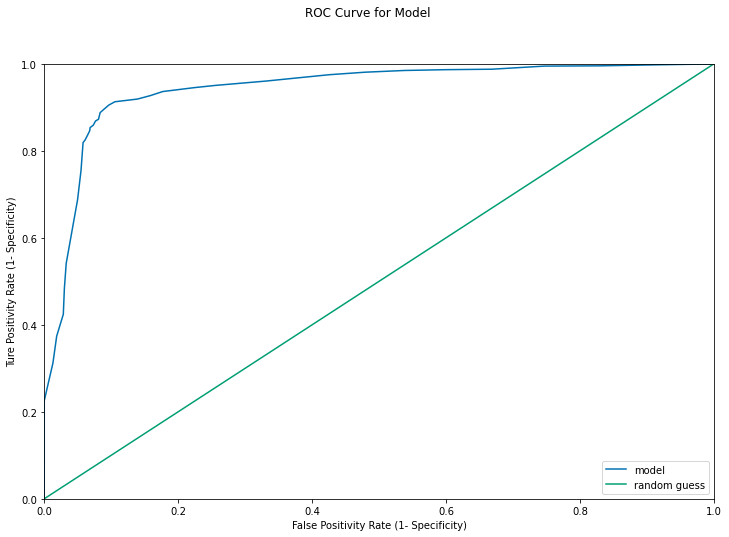

In [39]:
# Confusion matrix
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_features, X_train[features], y_train_access, ax=ax)
ax.grid(False)

#Weighted F1 score with optimal threshold if relevant
plot_f1_threshold(X_train[features], y_train_access, model_features)

#roc curve
plot_roc(y_train_access, model_features.predict_proba(X_train[features]))

Plot the classifications geospatially

In [40]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [41]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

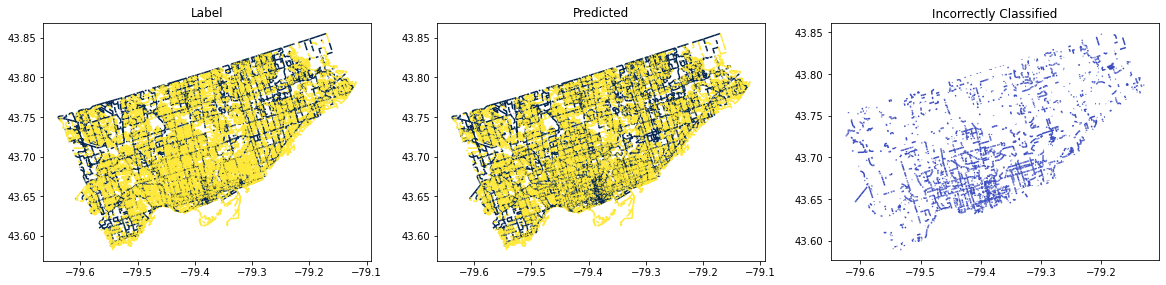

In [45]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['diff'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')

# Figure
fig, axs = plt.subplots(figsize=(20,12), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='cividis')
plotr.plot(ax=axs[1], column=0, cmap='cividis')
plotr[plotr['diff'] == 'incorrect'].plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

plt.show()